Highest income locations.

In [2]:

df_simple_rent = con.execute("""
    SELECT 
        l.nombre, 
        r.renta
    FROM silver.renta r
    JOIN silver.lugares l ON r.id = l.id
    ORDER BY r.renta DESC
    LIMIT 10;
""").df()

df_simple_rent



,nombre,renta
0,Pozuelo de Alarcón,30524
1,Ayegui/Aiegi agregacion de municipios,30242
2,"Aleixar, L' agregacion de municipios",28987
3,Aoiz/Agoitz agregacion de municipios,28682
4,Beriáin agregacion de municipios,27738
5,Matadepera,26720
6,Boadilla del Monte,26668
7,Alp agregacion de municipios,26282
8,Lakuntza agregacion de municipios,26251
9,Artajona agregacion de municipios,25968


Number of Non-Working Days per Month (2023)

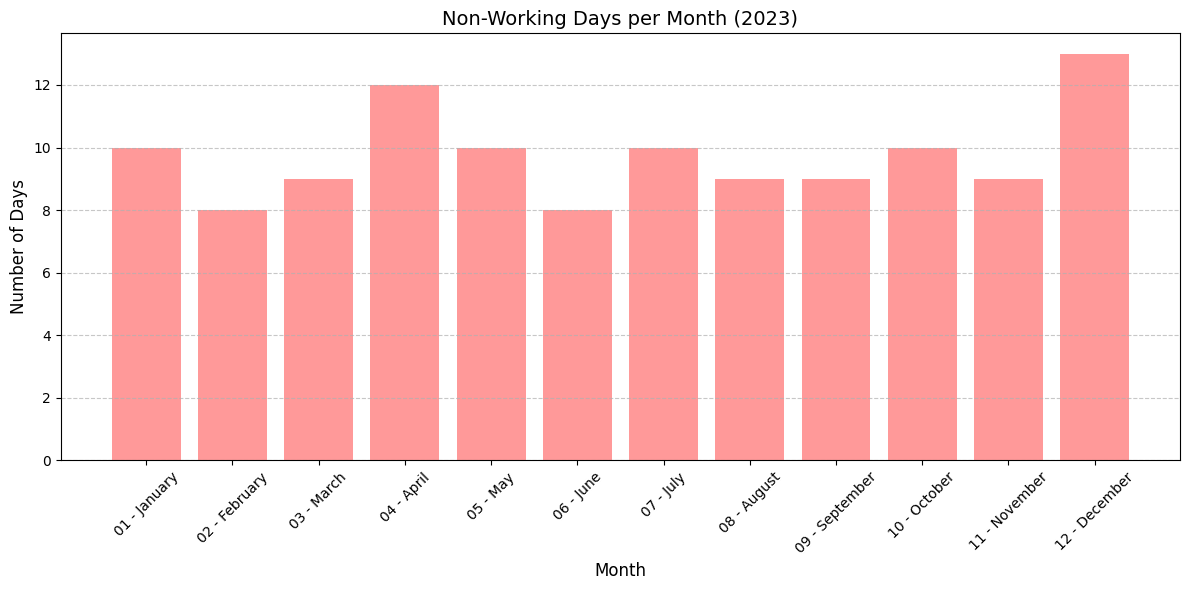

In [3]:
import matplotlib.pyplot as plt

# Query to count non-working days (tipo_dia = False) per month
df_non_working_days = con.execute("""
    SELECT 
        MONTH(fecha) as month_num,
        STRFTIME(fecha, '%m - %B') as month_name,
        COUNT(*) as non_working_days
    FROM silver.calendario
    WHERE tipo_dia = False
    GROUP BY month_num, month_name
    ORDER BY month_num;
""").df()

# Bar chart generation
plt.figure(figsize=(12, 6))
plt.bar(df_non_working_days['month_name'], df_non_working_days['non_working_days'], color='#ff9999')

# Aesthetic configuration
plt.title('Non-Working Days per Month (2023)', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Days', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display chart in the Notebook
plt.tight_layout()
plt.show()

Top 10 places with most population.

In [4]:

df_top_poblacion = con.execute("""
    SELECT 
        l.nombre, 
        p.poblacion
    FROM silver.lugares l
    JOIN silver.poblacion p ON l.id = p.id
    WHERE l.tipo_zona = 'municipio'
    ORDER BY p.poblacion DESC
    LIMIT 10;
""").df()

df_top_poblacion

,nombre,poblacion
0,Madrid,3332035
1,Barcelona,1660122
2,València,807693
3,Sevilla,684025
4,Zaragoza,682513
5,Málaga,586384
6,Murcia,469177
7,Palma,423350
8,"Palmas de Gran Canaria, Las",378027
9,Alicante/Alacant,349282


Show the locations inside the polygon in the Comunitat Valenciana.

In [3]:
import folium

poly = "POLYGON ((-0.219727 40.763901, -1.560059 39.554883, -0.74707 37.840157, 0.340576 38.728376, -0.230713 39.470125, 0.648193 40.597271, -0.219727 40.763901))"

df_mapa = con.execute(f"""
    SELECT id, nombre, latitude, longitude
    FROM silver.lugares
    WHERE ST_Contains(ST_GeomFromText('{poly}'), coordenadas)
""").df()

centro_lat = df_mapa['latitude'].mean()
centro_lon = df_mapa['longitude'].mean()

mapa_nb = folium.Map(location=[centro_lat, centro_lon], zoom_start=8)

for _, row in df_mapa.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"ID: {row['id']}<br>Nombre: {row['nombre']}",
        tooltip=row['nombre']
    ).add_to(mapa_nb)

![](mapa1.png)

We show in a map the polygons of the provinces of Spain

In [5]:
import folium
import json

df_provincias = con.execute("""
    SELECT 
        nombre_provincia, 
        ST_AsGeoJSON(geom) AS geom_json
    FROM silver.provincias
""").df()

mapa_provincias = folium.Map(location=[40.4168, -3.7038], zoom_start=6)

for _, row in df_provincias.iterrows():
    geojson_data = json.loads(row['geom_json'])
    
    folium.GeoJson(
        geojson_data,
        style_function=lambda x: {
            'fillColor': '#3186cc',
            'color': 'black',
            'weight': 1,
            'fillOpacity': 0.4
        },
        tooltip=row['nombre_provincia']
    ).add_to(mapa_provincias)

![](mapa2.png)

We check 10 trips which origin is València the last day of Fallas.

In [50]:
con.execute("""
    SELECT DISTINCT
        l_orig.nombre AS origen, 
        l_dest.nombre AS destino, 
        v.fecha, 
        v.viajes,
        v.periodo
    FROM 
        silver.viajes v
    JOIN 
        silver.lugares l_orig ON v.id_origen = l_orig.id
    JOIN 
        silver.lugares l_dest ON v.id_destino = l_dest.id
    WHERE 
        v.fecha = '2023-03-19' AND
        l_orig.nombre = 'València'
    LIMIT 10;
""").df()


,origen,destino,fecha,viajes,periodo
0,València,Benilloba agregacion de municipios,2023-03-19,2,8
1,València,Elche/Elx,2023-03-19,11,8
2,València,Barcelona,2023-03-19,6,8
3,València,Cádiz,2023-03-19,15,8
4,València,Chilches/Xilxes,2023-03-19,4,8
5,València,Segorbe,2023-03-19,2,8
6,València,Ciudad Real,2023-03-19,5,8
7,València,Cuenca,2023-03-19,12,8
8,València,Baeza,2023-03-19,4,8
9,València,Begíjar,2023-03-19,12,8
